In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [2]:
tf.keras.backend.clear_session()

In [3]:
# Paths to your local dataset
base_dir = 'D:/Rice Leaf Diseases Dataset'

In [4]:
# Image dimensions and batch size
img_height, img_width = 227, 227
batch_size = 16

In [5]:
# Data augmentation with additional techniques
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Reserve 20% of data for validation
)

train_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 6946 images belonging to 4 classes.
Found 1735 images belonging to 4 classes.


In [6]:
# Compute class weights to handle class imbalance
class_labels = train_generator.class_indices
class_weights = compute_class_weight('balanced', classes=np.arange(len(class_labels)), y=train_generator.classes)
class_weights_dict = dict(enumerate(class_weights))

In [7]:
# Load the DenseNet121 model with pre-trained weights, excluding the top layer
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

In [8]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.6)(x)  # Increased dropout rate
predictions = Dense(4, activation='softmax')(x)  # 4 classes

In [9]:
# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# Unfreeze more layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])# Unfreeze more layers for fine-tuning
for layer in base_model.layers:
    layer.trainable = True

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Implement callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [12]:
# Train the model with more epochs and callbacks
history = model.fit(
    train_generator,
    epochs=20,  # Increased epochs for better training
    validation_data=val_generator,
    callbacks=[reduce_lr, early_stop],
    class_weight=class_weights_dict
)

Epoch 1/20
435/435 [==============================] - 581s 1s/step - loss: 0.9904 - accuracy: 0.6061 - val_loss: 1.0931 - val_accuracy: 0.6519 - lr: 1.0000e-05
Epoch 2/20
435/435 [==============================] - 469s 1s/step - loss: 0.4721 - accuracy: 0.8285 - val_loss: 0.9209 - val_accuracy: 0.7343 - lr: 1.0000e-05
Epoch 3/20
435/435 [==============================] - 468s 1s/step - loss: 0.2994 - accuracy: 0.9008 - val_loss: 0.9653 - val_accuracy: 0.7591 - lr: 1.0000e-05
Epoch 4/20
435/435 [==============================] - 468s 1s/step - loss: 0.2228 - accuracy: 0.9266 - val_loss: 1.0375 - val_accuracy: 0.7798 - lr: 1.0000e-05
Epoch 5/20
435/435 [==============================] - 499s 1s/step - loss: 0.1567 - accuracy: 0.9500 - val_loss: 1.0254 - val_accuracy: 0.8040 - lr: 1.0000e-05
Epoch 6/20
435/435 [==============================] - 494s 1s/step - loss: 0.1291 - accuracy: 0.9597 - val_loss: 1.1073 - val_accuracy: 0.8138 - lr: 1.0000e-05
Epoch 7/20
435/435 [====================

In [13]:
# Evaluate the model on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f'Validation accuracy: {val_acc:.2f}')

109/109 [==============================] - 131s 1s/step - loss: 0.9249 - accuracy: 0.7314
Validation accuracy: 0.73


In [14]:
# Save the model in the native Keras format
model.save('soyabean_densenet121_model_improved.keras')

In [16]:
!pip install matplotlib seaborn

   ---------------------------------------- 0.0/7.5 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.5 MB ? eta -:--:--
   ---- ----------------------------------- 0.8/7.5 MB 2.2 MB/s eta 0:00:03
   ------ --------------------------------- 1.3/7.5 MB 2.1 MB/s eta 0:00:03
   ----------- ---------------------------- 2.1/7.5 MB 2.3 MB/s eta 0:00:03
   ------------- -------------------------- 2.6/7.5 MB 2.5 MB/s eta 0:00:02
   ---------------- ----------------------- 3.1/7.5 MB 2.5 MB/s eta 0:00:02
   ------------------ --------------------- 3.4/7.5 MB 2.3 MB/s eta 0:00:02
   -------------------- ------------------- 3.9/7.5 MB 2.3 MB/s eta 0:00:02
   -------------------------- ------------- 5.0/7.5 MB 2.7 MB/s eta 0:00:01
   -------------------------------- ------- 6.0/7.5 MB 2.9 MB/s eta 0:00:01
   ------------------------------------- -- 7.1/7.5 MB 3.1 MB/s eta 0:00:01
   ---------------------------------------- 7.5/7.5 MB 3.1 MB/s eta 0:00:00
   -----------------------

In [17]:
# Import necessary libraries for plotting and evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

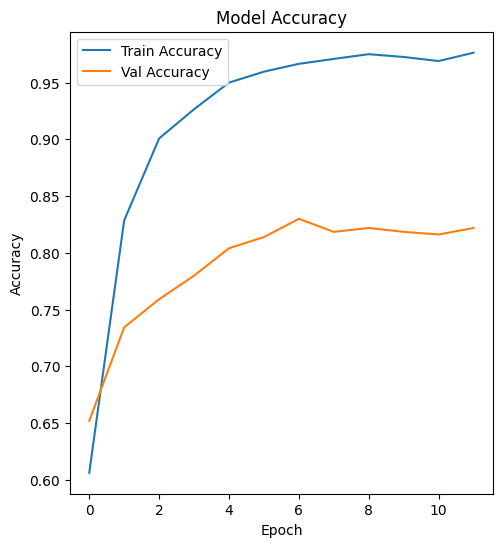

In [18]:
# Assuming 'history' is the result of model.fit()
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

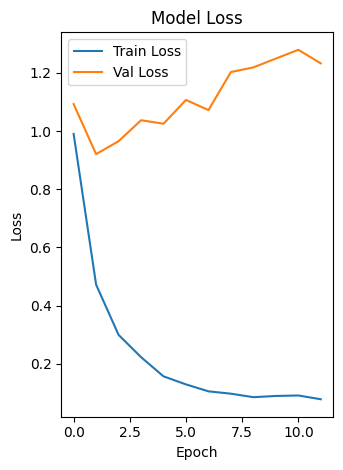

In [19]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()